# Hierarchical Clustering

In [12]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [70]:
df = pd.read_csv("./clean_dataset.csv")

def exclude_columns(df, columns_to_exclude):
    return df.drop(columns=columns_to_exclude)

columns_to_exclude = ['MildOutlier', "Class"]
df_num = exclude_columns(df, columns_to_exclude)

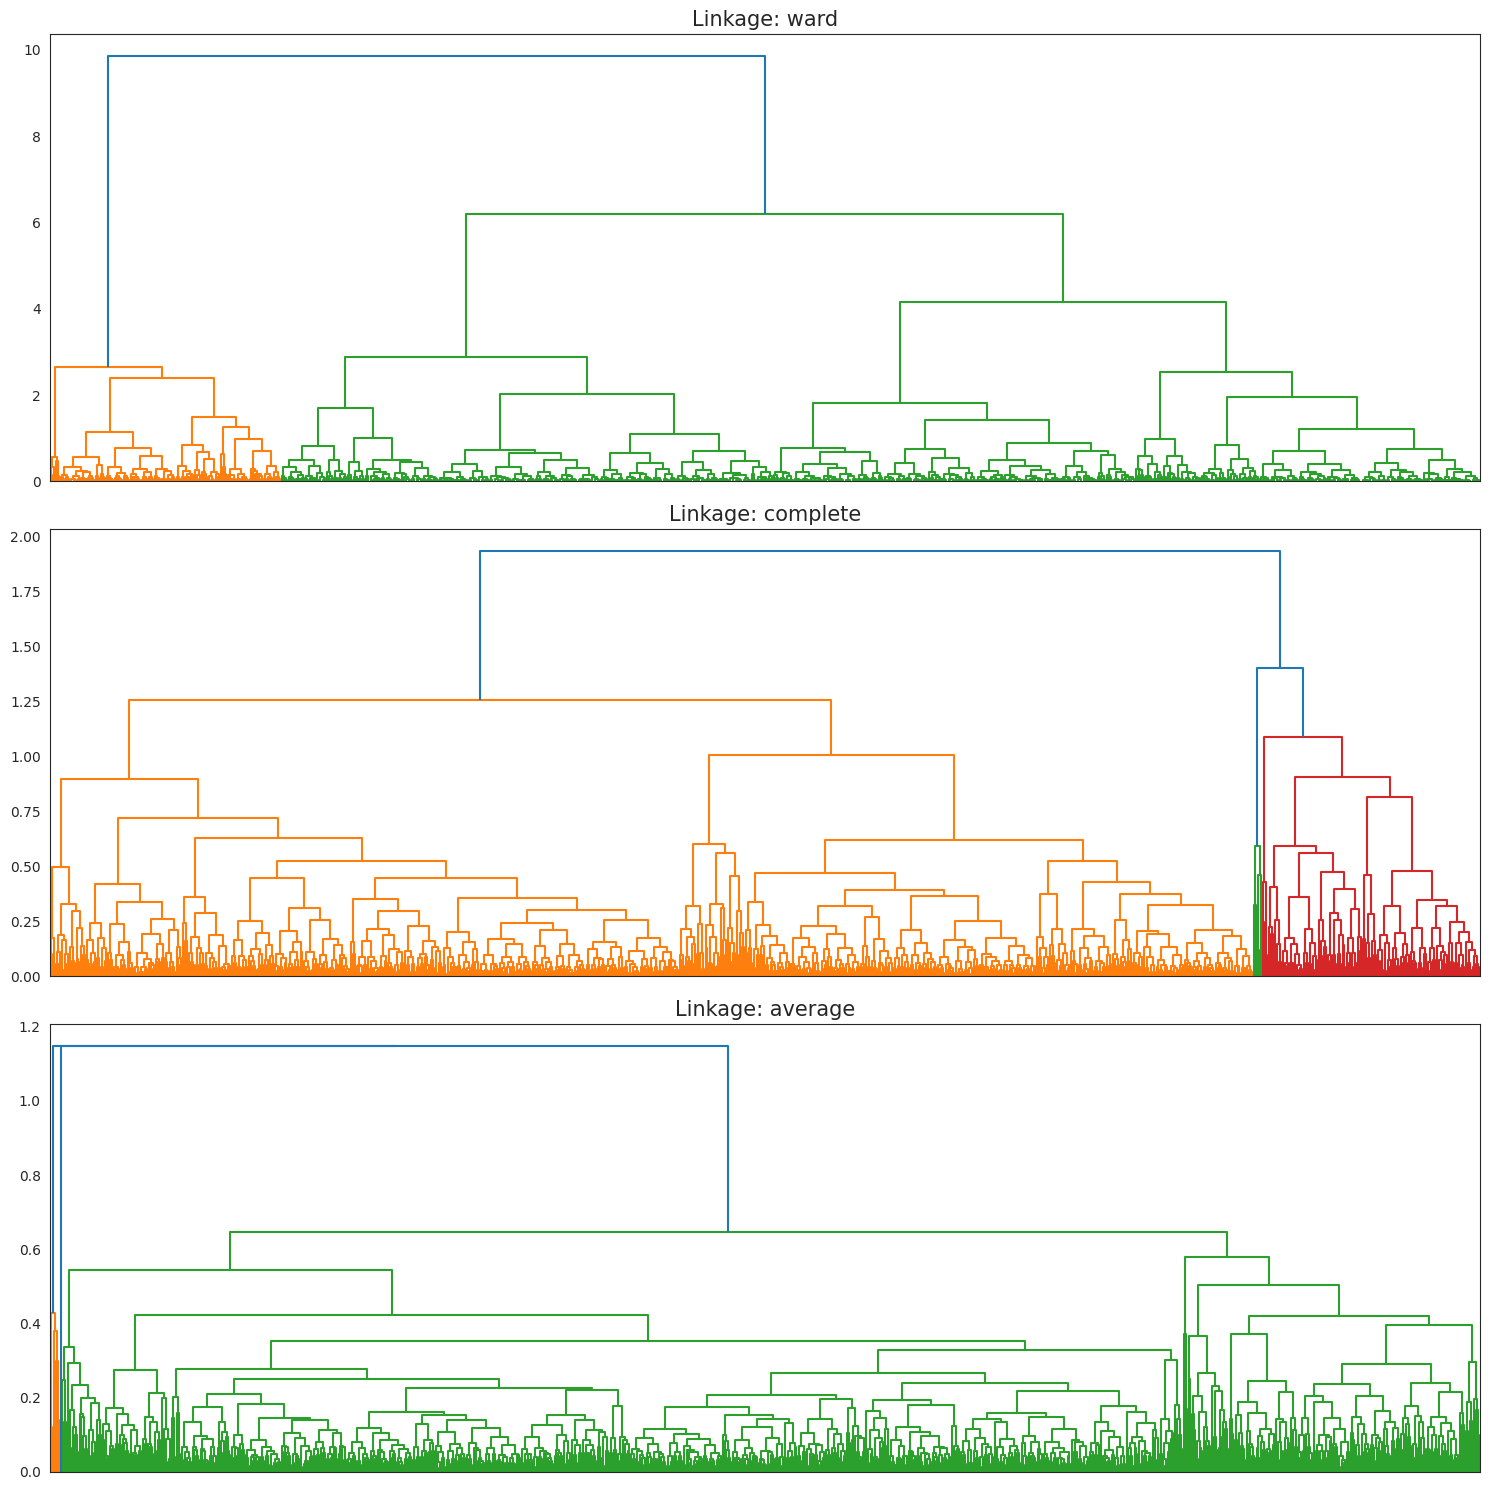

In [71]:
sns.set_style("white")
fig, axs = plt.subplots(3, figsize=(15, 15))

for lin, row, col in [
    ("ward", 0, 0),
    ("complete", 1, 1),
    ("average", 2, 0),
]:
    Z = linkage(df_num, lin)
    dendrogram(Z, no_labels=True, ax=axs[row])
    axs[row].set_title(f"Linkage: {lin}", fontsize=15)

plt.tight_layout()


In [77]:
def plot_umap(embedding_df, title, ax, hue="Cluster", palette="viridis", n_clusters=None, style=None):
    # Adjust the palette based on the number of unique hue values if n_clusters is not given
    unique_hue_values = embedding_df[hue].nunique() if n_clusters is None else n_clusters
    palette = sns.color_palette(palette, n_colors=unique_hue_values)
    
    # Ensure style column exists in embedding_df
    if style and style in embedding_df.columns:
        # Plot non-outliers with default 'o' marker
        sns.scatterplot(
            data=embedding_df[embedding_df[style] == 0],  # Select non-outliers
            x="UMAP1",
            y="UMAP2",
            hue=hue,
            palette=palette,
            ax=ax,
            legend="full",
            marker='o'
        )
        
        # Overlay outliers with 'X' marker if any outliers are present
        if embedding_df[style].any():
            sns.scatterplot(
                data=embedding_df[embedding_df[style] == 1],  # Select outliers
                x="UMAP1",
                y="UMAP2",
                hue=hue,
                palette=palette,
                ax=ax,
                legend=False,
                marker='X'
            )
    else:
        # If no style column, plot all points with default 'o' marker
        sns.scatterplot(
            data=embedding_df,
            x="UMAP1",
            y="UMAP2",
            hue=hue,
            palette=palette,
            ax=ax,
            legend="full",
            marker='o'
        )
    
    ax.legend(title=title)
    ax.set_title(f"UMAP projection with {title}")


/tmp/ipykernel_35404/1302268958.py:22: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(


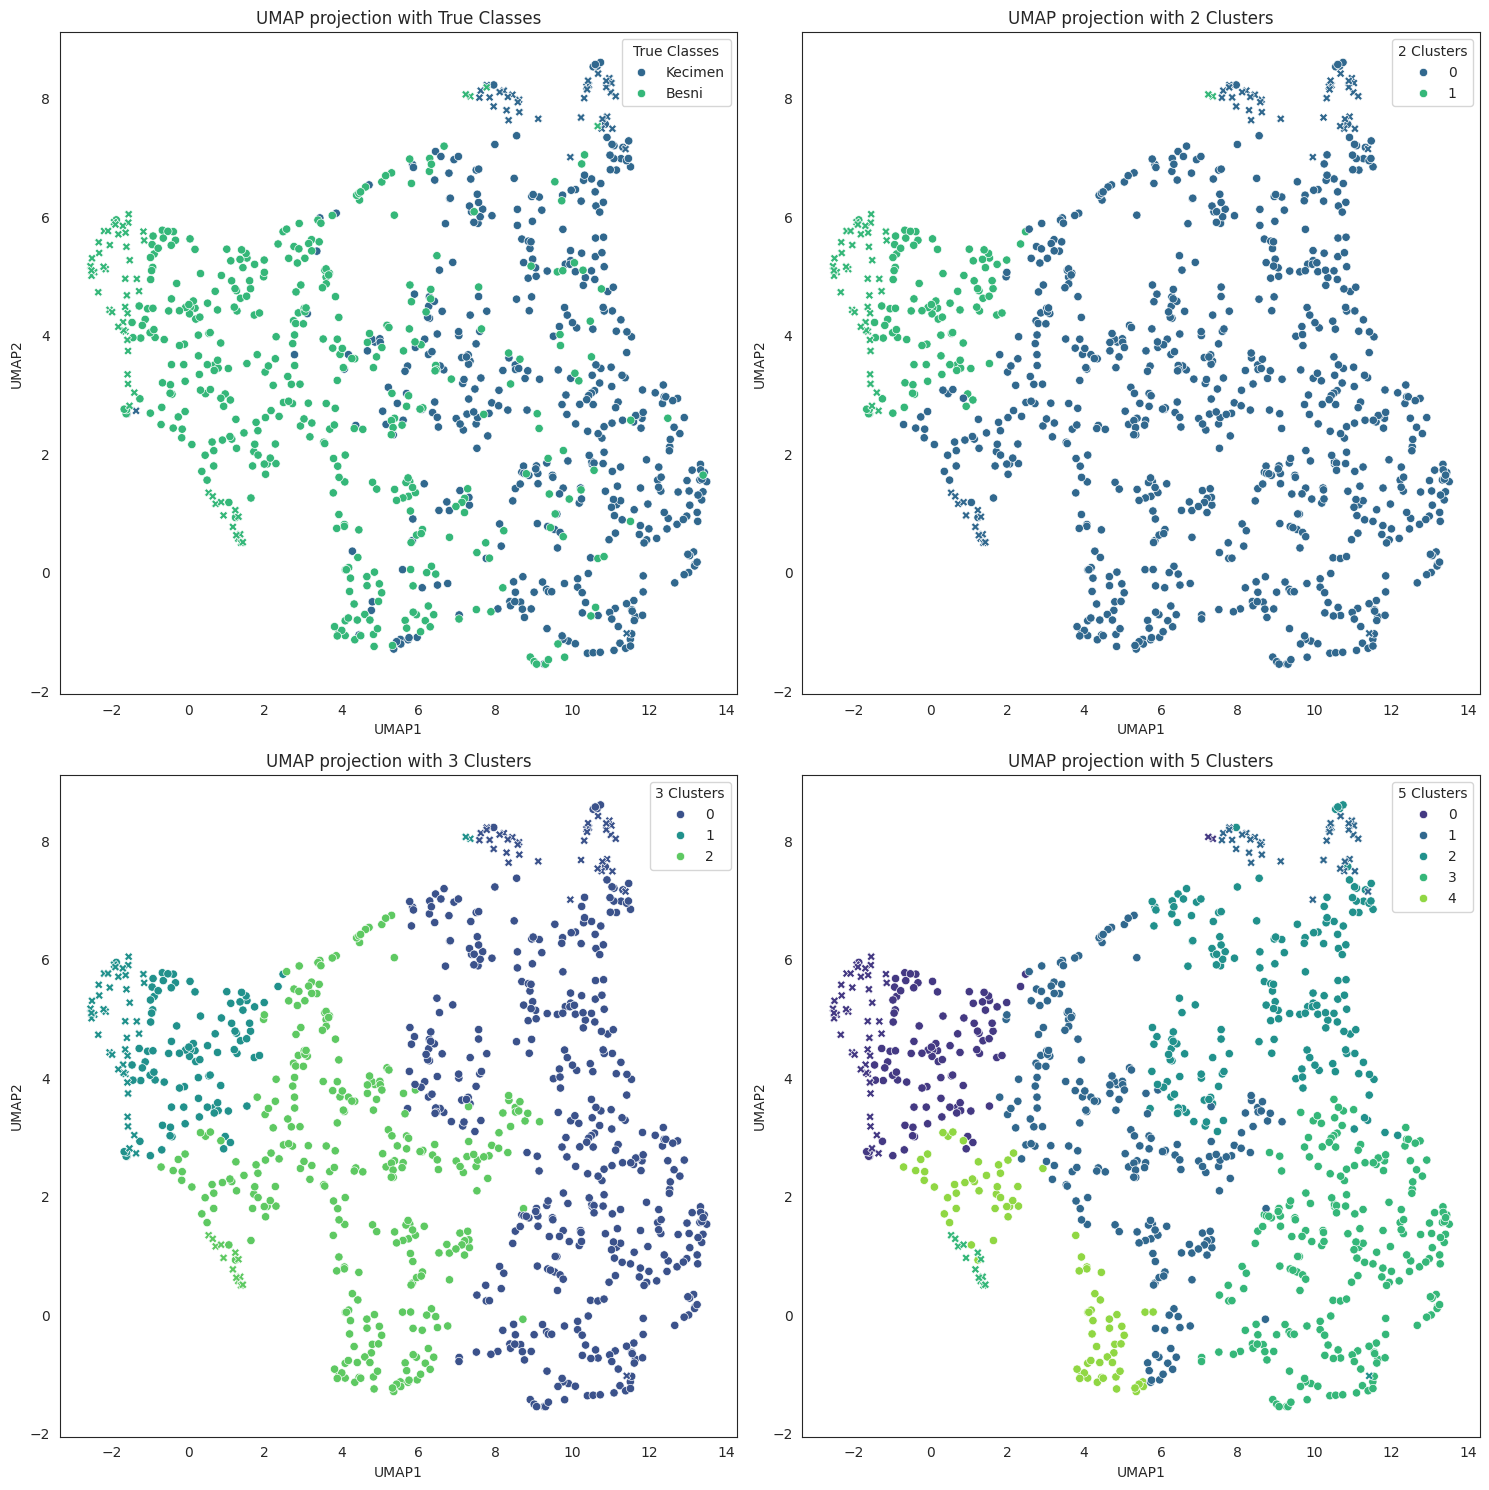

In [78]:
sns.set_style("white")
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

reducer = umap.UMAP(
    n_neighbors=10, min_dist=0.3, metric="euclidean", random_state=69, n_jobs=1
)
embedding = reducer.fit_transform(df_num)

embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
embedding_df["Cluster"] = df["Class"]
embedding_df["MildOutlier"] = df["MildOutlier"]  

plot_umap(embedding_df, "True Classes", axs[0, 0], style='MildOutlier')

results = [embedding_df.copy()]
for row, col, n_clusters in [(0, 1, 2), (1, 0, 3), (1, 1, 5)]:

    hc = AgglomerativeClustering(
        n_clusters=n_clusters, metric="euclidean", linkage="ward"
    )
    y_hc = hc.fit_predict(df_num)

    embedding_df["Cluster"] = y_hc

    results.append(embedding_df.copy())

    plot_umap(
        embedding_df,
        f"{n_clusters} Clusters",
        axs[row, col],
        hue="Cluster",
        n_clusters=n_clusters,
        style='MildOutlier'
    )

plt.tight_layout()
plt.show()


In [79]:
for res in results[:3]:
    cluster_names = res["Cluster"].unique()
    for cn in cluster_names:
        print(f"Cluster {cn} out of {len(cluster_names)}")
        # TODO: output as latex table
        print(
            res.loc[res["Cluster"] == cn]
            .drop("Cluster", axis=1)
            .describe()
            .drop("count")
            .rename(
                index={
                    "mean": "Mean",
                    "std": "Std",
                    "min": "Min",
                    "50%": "Med",
                    "25%": "1Q",
                    "75%": "3Q",
                    "max": "Max",
                }
            )
        )
        print("\n")


Cluster Kecimen out of 2
          UMAP1     UMAP2  MildOutlier
Mean   9.355232  3.195992     0.080000
Std    2.415465  2.733166     0.271595
Min   -1.590565 -1.540947     0.000000
1Q     7.571801  1.141106     0.000000
Med    9.801629  2.894134     0.000000
3Q    11.075140  5.326323     0.000000
Max   13.503325  8.616141     1.000000


Cluster Besni out of 2
          UMAP1     UMAP2  MildOutlier
Mean   3.224123  3.141059     0.131111
Std    3.511817  2.160909     0.337897
Min   -2.540622 -1.543026     0.000000
1Q     0.465641  1.546363     0.000000
Med    3.010635  3.451608     0.000000
3Q     5.691823  4.820572     0.000000
Max   13.410320  8.195477     1.000000


Cluster 0 out of 2
          UMAP1     UMAP2  MildOutlier
Mean   7.567410  2.899894     0.066225
Std    3.381097  2.566521     0.248840
Min   -0.702216 -1.543026     0.000000
1Q     4.970000  0.987343     0.000000
Med    7.836909  2.673921     0.000000
3Q    10.493942  4.722422     0.000000
Max   13.503325  8.616141     1.

### Reversed

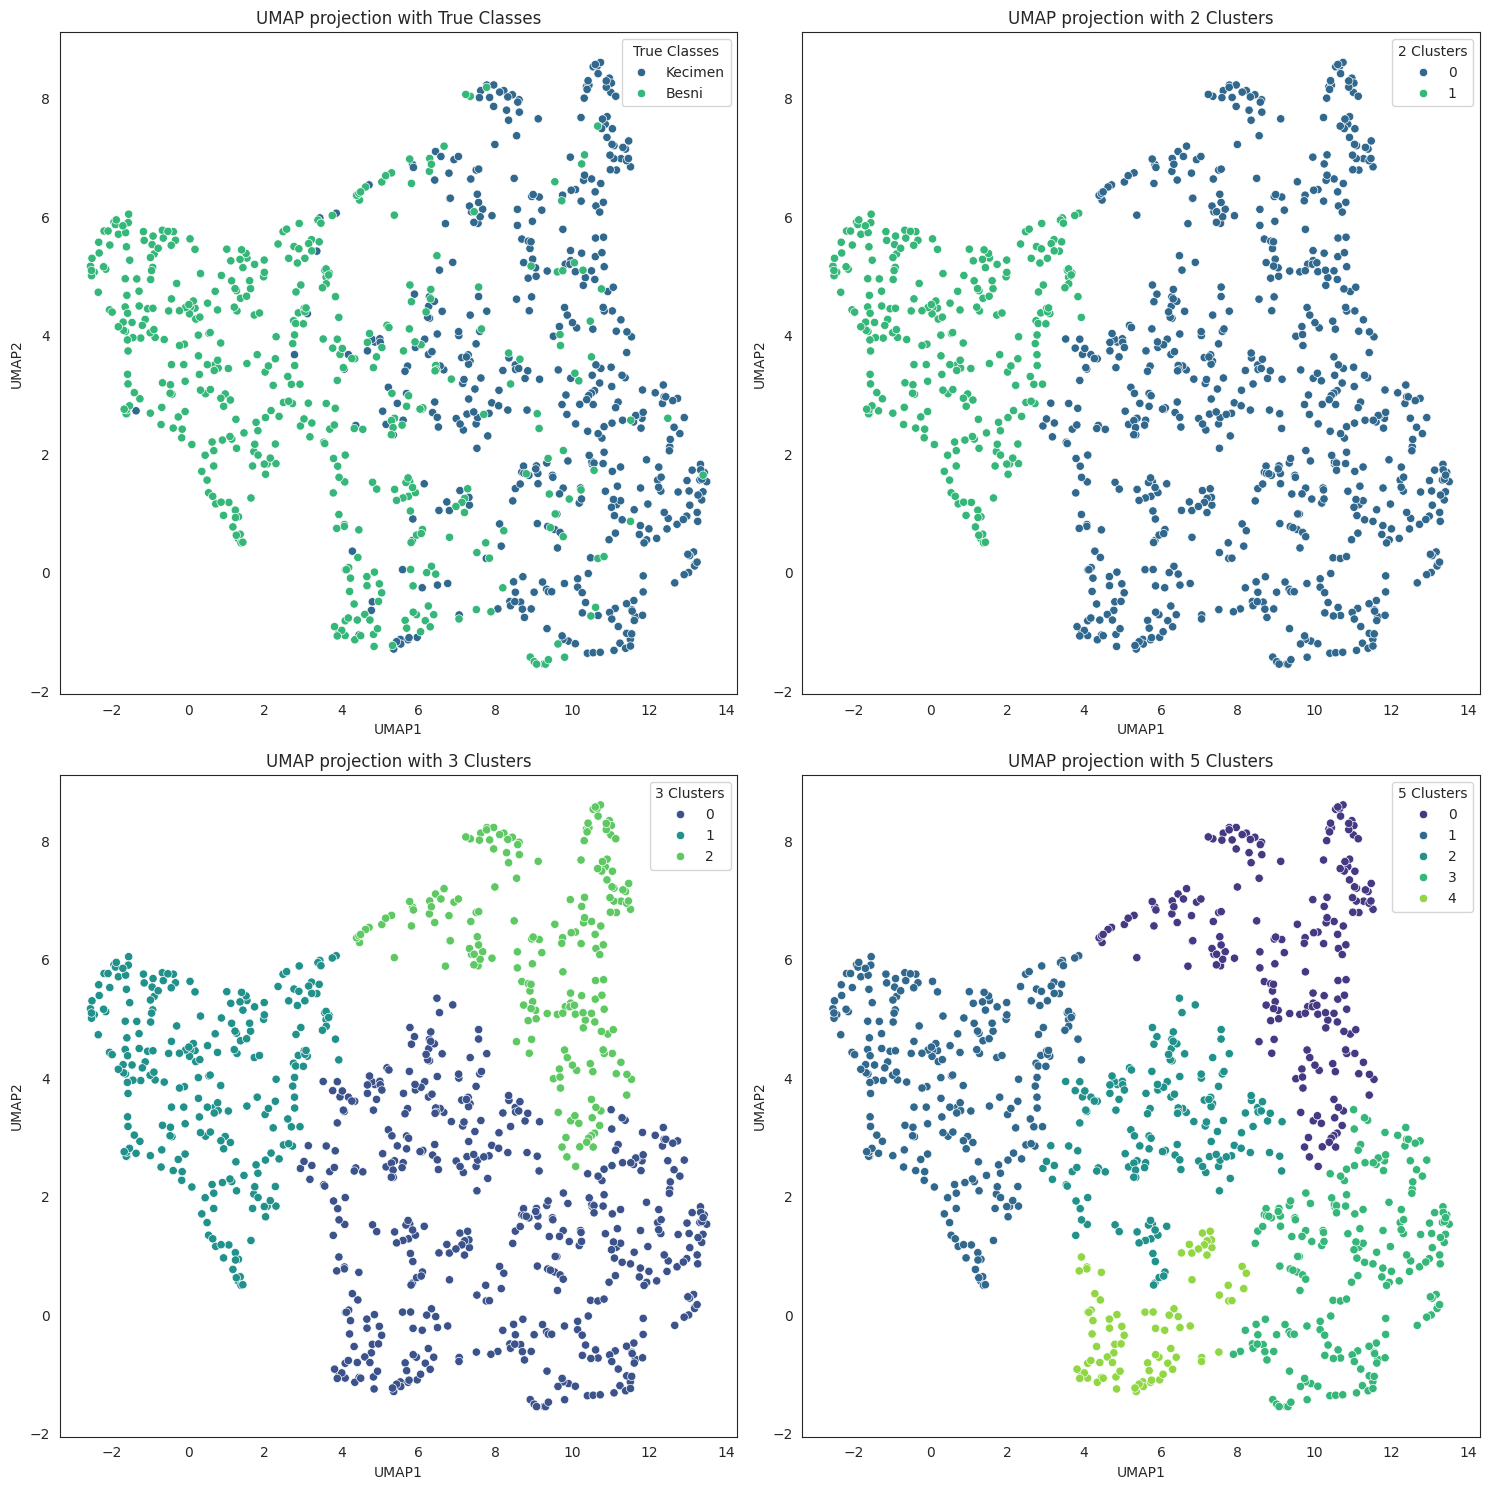

In [82]:
sns.set_style("white")
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

reducer = umap.UMAP(
    n_neighbors=10, min_dist=0.3, metric="euclidean", random_state=69, n_jobs=1
)
embedding = reducer.fit_transform(df_num)

embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])

embedding_df["Cluster"] = df["Class"]
plot_umap(embedding_df, "True Classes", axs[0, 0], hue="Cluster")

for row, col, n_clusters in [(0, 1, 2), (1, 0, 3), (1, 1, 5)]:
    hc = AgglomerativeClustering(
        n_clusters=n_clusters, metric="euclidean", linkage="ward"
    )
    embedding_df["Cluster"] = hc.fit_predict(embedding)

    plot_umap(
        embedding_df,
        f"{n_clusters} Clusters",
        axs[row, col],
        hue="Cluster",
        n_clusters=n_clusters,
    )

plt.tight_layout()
plt.show()
